## Description

* Follow a filter-based approach where we assign weights to each property feature (negative values to penalize undesirable features like gun violence score and price, and positive values to reward others like the size of the living area). 
* Using the lineal combination of weights and features we calculate a desirability score for every property in the dataset, the higher the score the more desirable the property. 
* Then we sort the properties by desirability score and label the top 10% as favorite and the bottom 10% as not favorite. 
* Then we use this data to train and test the classification model


In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from arcgis.gis import GIS
import geopy.distance

In [198]:
gis = GIS()

In [199]:
def scatter_score(df, col):
    sns.jointplot(col, 'score', data=df)
    plt.title("Score v.s {}".format(col))
    
def six_sigma_filter(df, column):
    sigma = df[column].std()
    mu = df[column].mean()
    three_sigma = [mu-(3*sigma), mu+(3*sigma)]
    print("Column:{}, Mean:{}, Sigma:{}, 6 sigma_range: {}:{}".format(column,mu,
                                                                       sigma,
                                                                       three_sigma[0],
                                                                       three_sigma[1]))
    
    # filter
    df_to_keep = df[(df[column] > three_sigma[0]) & (df[column] < three_sigma[1])]
    
    # prints
    num_rows_dropped = df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep

def min_max_scale(df, cols):
    mm_scaler = MinMaxScaler() 
    scaled_array = mm_scaler.fit_transform(df[cols])
    return pd.DataFrame(scaled_array, columns=cols)

def draw(df, col, map_widget, cmap='YlRd', class_count=10, renderer_type='c'):
    df.spatial.plot(map_widget=map_widget,
                class_count=class_count,
                renderer_type=renderer_type,
                method='esriClassifyNaturalBreaks',
                col=col,
                cmap=cmap,
                alpha=0.8,
                outline_color=[0,0,0,0])
    
def between_quantiles(df, col, q_min=0.0, q_max=1.0):
    q_val_min = df[col].quantile(q_min)
    q_val_max = df[col].quantile(q_max)
    return df[(df[col] <= q_val_max) & (df[col] >= q_val_min) ].reset_index(drop=True)

def distance(point1, point2):
    coords_1 = (point1['y'], point1['x'])
    coords_2 = (point2['y'], point2['x'])
    return geopy.distance.geodesic(coords_1, coords_2).miles

def set_commute(row):
    coord = {'x': row['X'], 'y': row['Y']}
    return distance(airport_coord, coord)

In [200]:
airport_coord = {'x':-80.275173, 'y': 25.796626}

In [201]:
facilities_path = '../Data/arcgis/neighborhood_facilities_2019_1_miles.csv'
gun_violence_path = '../Data/arcgis/property_point_view_2019_gun_viol_totals_1.0_miles.csv'
prop_path = '../Data/arcgis/property_point_view_2019.csv'

In [202]:
gv_df = pd.read_csv(gun_violence_path)

# Compute gun violence score
incidents_weight = 1.0
injured_weight = 1.5
killed_weight = 2.0
n_years = 5


gv_df['gv_score'] = (killed_weight*gv_df['killed_count'] + injured_weight*gv_df['injured_count'] +  incidents_weight*gv_df['incident_count'])/n_years
gv_df.head()

property_index  incident_count  injured_count  killed_count  gv_score
0               0              72             71            27      46.5
1               1              64             67            24      42.5
2               2              65             68            24      43.0
3               3              68             67            27      44.5
4               4              68             69            26      44.7

In [203]:
facilities_df = pd.read_csv(facilities_path)
prop_df = pd.read_csv(prop_path)

# replace condo flag: N--> 0 , Y --> 1
prop_df.replace({'CONDO_FLAG' : {'Y': 1, 'N':0}}, inplace=True)
prop_df['AGE'] = 2019 - prop_df['YEAR_BUILT'] 
prop_df['OUTDOORS_AREA'] = prop_df['BUILDING_ACTUAL_AREA'] - prop_df['BUILDING_HEATED_AREA'] 

## Merge datasets

In [204]:
merged_df = prop_df.merge(gv_df, left_index=True, right_index=True)
merged_df = merged_df.merge(facilities_df, left_index=True, right_index=True)
print(merged_df.columns)
merged_df.describe()

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA',
       'property_index', 'incident_count', 'injured_count', 'killed_count',
       'gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count',
       'coffee_count', 'bars_count', 'gas_count', 'parks_count', 'edu_count'],
      dtype='object')


X             Y           ZIP    CONDO_FLAG  BEDROOM_COUNT  \
count  16399.000000  16399.000000  16399.000000  16399.000000   16399.000000   
mean     -80.300882     25.758936  33128.900116      0.349777       2.682237   
std        0.103181      0.141156     59.874734      0.476914       1.093315   
min      -80.557561     25.399216  33010.000000      0.000000       0.000000   
25%      -80.385921     25.670566  33125.000000      0.000000       2.000000   
50%      -80.314025     25.771513  33149.000000      0.000000       3.000000   
75%      -80.207915     25.875636  33176.000000      1.000000       3.000000   
max      -80.119450     25.974065  33196.000000      1.000000       9.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT    UNIT_COUNT  \
count    16399.000000         16399.000000  16399.000000  16399.000000   
mean         1.830356             0.143728      0.816208      1.033600   
std          0.687652             0.354112      0.707756      0.180202   
min          0.000000             0.000000      0.000000      1.000000   
25%          1.000000             0.000000      0.000000      1.000000   
50%          2.000000             0.000000      1.000000      1.000000   
75%          2.000000             0.000000      1.000000      1.000000   
max          6.000000             2.000000     11.000000      2.000000   

       BUILDING_ACTUAL_AREA  ...  killed_count      gv_score  grocery_count  \
count          16399.000000  ...  16399.000000  16399.000000   16399.000000   
mean            1648.555766  ...      4.422038      6.548271       3.572962   
std              737.329084  ...      6.608888      9.987854       3.502307   
min              500.000000  ...      0.000000      0.000000       0.000000   
25%             1089.000000  ...      1.000000      1.100000       1.000000   
50%             1516.000000  ...      2.000000      3.000000       3.000000   
75%             2065.000000  ...      5.000000      7.400000       5.000000   
max             5923.000000  ...     55.000000     85.100000      20.000000   

       restaurant_count  hospitals_count  coffee_count  bars_count  \
count      16399.000000     16399.000000  16399.000000     16399.0   
mean          13.516922         0.162510      1.844259         0.0   
std            7.631967         0.593595      3.182598         0.0   
min            0.000000         0.000000      0.000000         0.0   
25%            6.000000         0.000000      0.000000         0.0   
50%           18.000000         0.000000      1.000000         0.0   
75%           20.000000         0.000000      2.000000         0.0   
max           20.000000         6.000000     20.000000         0.0   

          gas_count   parks_count     edu_count  
count  16399.000000  16399.000000  16399.000000  
mean       2.719495      4.128301      3.925483  
std        2.303580      3.977327      2.847690  
min        0.000000      0.000000      0.000000  
25%        1.000000      1.000000      2.000000  
50%        2.000000      3.000000      3.000000  
75%        4.000000      6.000000      5.000000  
max       15.000000     20.000000     20.000000  

[8 rows x 32 columns]

## Filter merged dataset

In [205]:
merged_df = merged_df[(merged_df.BEDROOM_COUNT > 0) & 
                  (merged_df.BATHROOM_COUNT > 0) &
                  (merged_df.FLOOR_COUNT > 0) & 
                  (merged_df.FLOOR_COUNT <= 3) & 
                  (merged_df.SQRD_FOOT_PRICE <= 700) &
                  (merged_df.OUTDOORS_AREA >= 0)]

merged_df['commute'] = merged_df.apply(set_commute, axis=1)

merged_df.describe()

X             Y           ZIP    CONDO_FLAG  BEDROOM_COUNT  \
count  10300.000000  10300.000000  10300.000000  10300.000000   10300.000000   
mean     -80.328537     25.738494  33125.222233      0.015243       3.168058   
std        0.090334      0.150788     63.863139      0.122523       0.798465   
min      -80.557561     25.399216  33010.000000      0.000000       1.000000   
25%      -80.405133     25.612949  33054.000000      0.000000       3.000000   
50%      -80.339710     25.747130  33156.000000      0.000000       3.000000   
75%      -80.246299     25.873502  33176.000000      0.000000       4.000000   
max      -80.120345     25.974065  33196.000000      1.000000       9.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT    UNIT_COUNT  \
count     10300.00000         10300.000000  10300.000000  10300.000000   
mean          1.94301             0.102233      1.196117      1.049515   
std           0.64897             0.306474      0.399028      0.216950   
min           1.00000             0.000000      1.000000      1.000000   
25%           2.00000             0.000000      1.000000      1.000000   
50%           2.00000             0.000000      1.000000      1.000000   
75%           2.00000             0.000000      1.000000      1.000000   
max           6.00000             2.000000      3.000000      2.000000   

       BUILDING_ACTUAL_AREA  ...      gv_score  grocery_count  \
count          10300.000000  ...  10300.000000   10300.000000   
mean            1961.497184  ...      7.026388       2.969806   
std              697.666720  ...     11.363776       3.029095   
min              544.000000  ...      0.000000       0.000000   
25%             1453.750000  ...      1.000000       1.000000   
50%             1848.000000  ...      2.800000       2.000000   
75%             2338.000000  ...      7.800000       4.000000   
max             5923.000000  ...     85.100000      20.000000   

       restaurant_count  hospitals_count  coffee_count  bars_count  \
count      10300.000000     10300.000000  10300.000000     10300.0   
mean          11.465631         0.160000      0.838252         0.0   
std            7.807874         0.577629      1.198460         0.0   
min            0.000000         0.000000      0.000000         0.0   
25%            4.000000         0.000000      0.000000         0.0   
50%           12.000000         0.000000      0.000000         0.0   
75%           20.000000         0.000000      1.000000         0.0   
max           20.000000         6.000000     12.000000         0.0   

          gas_count   parks_count     edu_count       commute  
count  10300.000000  10300.000000  10300.000000  10300.000000  
mean       2.779126      3.276602      3.890000     11.238865  
std        2.424398      3.189776      2.781773      6.343368  
min        0.000000      0.000000      0.000000      0.647608  
25%        1.000000      1.000000      2.000000      6.460674  
50%        2.000000      2.000000      3.000000     10.301267  
75%        4.000000      4.000000      5.000000     14.740954  
max       14.000000     20.000000     20.000000     31.532588  

[8 rows x 33 columns]

## Scores

In [206]:
merged_df.columns

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA',
       'property_index', 'incident_count', 'injured_count', 'killed_count',
       'gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count',
       'coffee_count', 'bars_count', 'gas_count', 'parks_count', 'edu_count',
       'commute'],
      dtype='object')

In [207]:
def set_scores(row):
    score = ((row['PRICE_1']*-1.5) + 
             (row['BEDROOM_COUNT']*1)+
             (row['BATHROOM_COUNT']*1)+
             (row['BUILDING_ACTUAL_AREA']*1)+
             (row['YEAR_BUILT']*1)+
             (row['HALF_BATHROOM_COUNT']*0.5)+ 
             (row['grocery_count']*1)+ 
             (row['coffee_count']*1)+
             (row['parks_count']*1.5)+
             (row['edu_count']*1.5)+
             (row['gv_score']*-2)+
             (row['commute']*-3.0)
            )
    return score

In [208]:
merged_df['score'] = merged_df.apply(set_scores, axis=1)
merged_df.head()

X          Y         CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0 -80.201382  25.843438  NORTH MIAMI  33150.0           0            2.0   
1 -80.204222  25.845806        MIAMI  33150.0           0            3.0   
2 -80.203909  25.845515        MIAMI  33150.0           0            2.0   
3 -80.206837  25.846260        MIAMI  33150.0           0            4.0   
4 -80.201535  25.844182  MIAMI BEACH  33150.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  UNIT_COUNT  ...  \
0             1.0                  0.0          1.0         1.0  ...   
1             1.0                  0.0          1.0         1.0  ...   
2             1.0                  0.0          1.0         1.0  ...   
3             4.0                  0.0          1.0         2.0  ...   
4             2.0                  0.0          1.0         1.0  ...   

   grocery_count  restaurant_count  hospitals_count  coffee_count  bars_count  \
0              5                18                0             0           0   
1              2                12                0             0           0   
2              2                12                0             0           0   
3              2                 7                0             0           0   
4              4                17                0             0           0   

   gas_count  parks_count edu_count   commute          score  
0          8            9         4  5.614387 -248921.343162  
1          7            6         4  5.567985 -234951.703955  
2          8            6         4  5.571407 -191976.714221  
3          3            6         6  5.459052 -356161.377156  
4          8            8         4  5.636220 -499138.308659  

[5 rows x 36 columns]

In [209]:
features = ['PRICE_1', 
        'BEDROOM_COUNT', 
        'BATHROOM_COUNT', 
        'BUILDING_ACTUAL_AREA', 
        'YEAR_BUILT', 
        'HALF_BATHROOM_COUNT', 
        'grocery_count',  
        'coffee_count', 
        'parks_count', 
        'edu_count', 
        'gv_score', 
        'commute']

scaled_df = min_max_scale(merged_df, features)
scaled_df.head()

PRICE_1  BEDROOM_COUNT  BATHROOM_COUNT  BUILDING_ACTUAL_AREA  YEAR_BUILT  \
0   0.1360          0.125             0.0              0.128834    0.194915   
1   0.1180          0.250             0.0              0.213608    0.296610   
2   0.0598          0.125             0.0              0.088492    0.296610   
3   0.2800          0.375             0.6              0.255438    0.822034   
4   0.4700          0.125             0.2              0.180889    0.203390   

   HALF_BATHROOM_COUNT  grocery_count  coffee_count  parks_count  edu_count  \
0                  0.0           0.25           0.0         0.45        0.2   
1                  0.0           0.10           0.0         0.30        0.2   
2                  0.0           0.10           0.0         0.30        0.2   
3                  0.0           0.10           0.0         0.30        0.3   
4                  0.0           0.20           0.0         0.40        0.2   

   gv_score   commute  
0  0.546416  0.160815  
1  0.499412  0.159313  
2  0.505288  0.159424  
3  0.522914  0.155786  
4  0.525264  0.161522

In [210]:
scaled_df['score'] = scaled_df.apply(set_scores, axis=1)


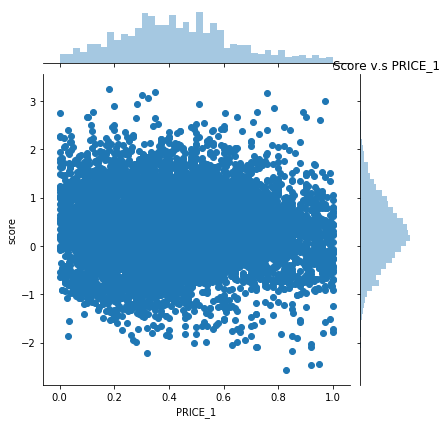

In [211]:
scatter_score(scaled_df, 'PRICE_1')

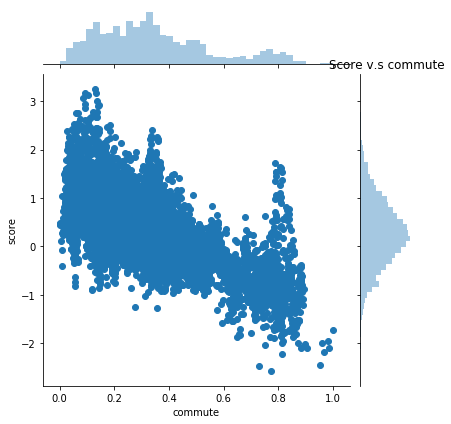

In [212]:
scatter_score(scaled_df, 'commute')

In [213]:
merged_df['score'] = scaled_df['score']

In [214]:
merged_df_sorted = merged_df.sort_values(by='score', ascending=False).reset_index()
merged_df_sorted.head()

index          X          Y   CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0  10158 -80.330977  25.596536  MIAMI  33157.0           0            3.0   
1    400 -80.246791  25.767662  MIAMI  33135.0           0            4.0   
2    862 -80.298212  25.764476  MIAMI  33144.0           0            2.0   
3    613 -80.180177  25.843648  MIAMI  33138.0           0            3.0   
4    399 -80.248733  25.772454  MIAMI  33125.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  ...  grocery_count  \
0             2.0                  0.0          1.0  ...              0   
1             3.0                  0.0          1.0  ...              5   
2             1.0                  0.0          1.0  ...              7   
3             2.0                  0.0          2.0  ...              3   
4             1.0                  0.0          1.0  ...             10   

   restaurant_count  hospitals_count  coffee_count  bars_count  gas_count  \
0                 0                0             0           0          0   
1                20                0             1           0          5   
2                20                0             3           0          2   
3                20                0             1           0          1   
4                20                0             1           0          7   

   parks_count  edu_count    commute     score  
0            5          2  14.206635  3.250833  
1            2          6   2.665371  3.177368  
2            3          4   2.638156  3.161239  
3            8          3   6.746025  3.123297  
4            2          6   2.341820  3.064584  

[5 rows x 37 columns]

In [215]:
merged_df_sorted['rank'] = merged_df_sorted.index
merged_df_sorted.describe()

index             X             Y           ZIP    CONDO_FLAG  \
count  10300.000000  10300.000000  10300.000000  10300.000000  10300.000000   
mean    5444.980680    -80.328537     25.738494  33125.222233      0.015243   
std     3243.829704      0.090334      0.150788     63.863139      0.122523   
min        0.000000    -80.557561     25.399216  33010.000000      0.000000   
25%     2676.750000    -80.405133     25.612949  33054.000000      0.000000   
50%     5357.000000    -80.339710     25.747130  33156.000000      0.000000   
75%     8156.250000    -80.246299     25.873502  33176.000000      0.000000   
max    16220.000000    -80.120345     25.974065  33196.000000      1.000000   

       BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT  \
count   10300.000000     10300.00000         10300.000000  10300.000000   
mean        3.168058         1.94301             0.102233      1.196117   
std         0.798465         0.64897             0.306474      0.399028   
min         1.000000         1.00000             0.000000      1.000000   
25%         3.000000         2.00000             0.000000      1.000000   
50%         3.000000         2.00000             0.000000      1.000000   
75%         4.000000         2.00000             0.000000      1.000000   
max         9.000000         6.00000             2.000000      3.000000   

         UNIT_COUNT  ...  restaurant_count  hospitals_count  coffee_count  \
count  10300.000000  ...      10300.000000     10300.000000  10300.000000   
mean       1.049515  ...         11.465631         0.160000      0.838252   
std        0.216950  ...          7.807874         0.577629      1.198460   
min        1.000000  ...          0.000000         0.000000      0.000000   
25%        1.000000  ...          4.000000         0.000000      0.000000   
50%        1.000000  ...         12.000000         0.000000      0.000000   
75%        1.000000  ...         20.000000         0.000000      1.000000   
max        2.000000  ...         20.000000         6.000000     12.000000   

       bars_count     gas_count   parks_count     edu_count       commute  \
count     10300.0  10300.000000  10300.000000  10300.000000  10300.000000   
mean          0.0      2.779126      3.276602      3.890000     11.238865   
std           0.0      2.424398      3.189776      2.781773      6.343368   
min           0.0      0.000000      0.000000      0.000000      0.647608   
25%           0.0      1.000000      1.000000      2.000000      6.460674   
50%           0.0      2.000000      2.000000      3.000000     10.301267   
75%           0.0      4.000000      4.000000      5.000000     14.740954   
max           0.0     14.000000     20.000000     20.000000     31.532588   

             score         rank  
count  9808.000000  10300.00000  
mean      0.293247   5149.50000  
std       0.709464   2973.49822  
min      -2.574393      0.00000  
25%      -0.158426   2574.75000  
50%       0.272825   5149.50000  
75%       0.743165   7724.25000  
max       3.250833  10299.00000  

[8 rows x 36 columns]

In [216]:
top_rank = 80

In [217]:
top_rank_df = merged_df_sorted[:top_rank]
top_rank_df

index          X          Y               CITY      ZIP  CONDO_FLAG  \
0   10158 -80.330977  25.596536              MIAMI  33157.0           0   
1     400 -80.246791  25.767662              MIAMI  33135.0           0   
2     862 -80.298212  25.764476              MIAMI  33144.0           0   
3     613 -80.180177  25.843648              MIAMI  33138.0           0   
4     399 -80.248733  25.772454              MIAMI  33125.0           0   
5    1331 -80.288447  25.852563            HIALEAH  33012.0           0   
6    3902 -80.215754  25.873598              MIAMI  33168.0           0   
7     841 -80.242705  25.746780              MIAMI  33145.0           0   
8     866 -80.292294  25.764652          DALY CITY  33144.0           0   
9    9846 -80.216141  25.956426            HIALEAH  33169.0           0   
10    864 -80.298163  25.764032              MIAMI  33144.0           0   
11    718 -80.222568  25.760299            HIALEAH  33145.0           0   
12   1459 -80.267405  25.851407            HIALEAH  33013.0           0   
13    207 -80.205015  25.809490              MIAMI  33127.0           0   
14    445 -80.257664  25.773706              MIAMI  33126.0           0   
15    181 -80.196969  25.831852              MIAMI  33127.0           0   
16    865 -80.296219  25.764372              MIAMI  33144.0           0   
17   1322 -80.314335  25.871367              MIAMI  33012.0           0   
18    705 -80.203280  25.829255              MIAMI  33127.0           0   
19   4239 -80.247364  25.850739              MIAMI  33147.0           0   
20    836 -80.232720  25.739673      COCONUT GROVE  33133.0           0   
21   9847 -80.218434  25.956319              MIAMI  33169.0           0   
22    229 -80.218054  25.800420              MIAMI  33142.0           0   
23    352 -80.199198  25.789048       PALMETTO BAY  33136.0           0   
24   1448 -80.280785  25.838865            HIALEAH  33010.0           0   
25    758 -80.300682  25.772556              MIAMI  33126.0           0   
26   9614 -80.259544  25.952829      MIAMI GARDENS  33056.0           0   
27    821 -80.230538  25.747115              MIAMI  33145.0           0   
28    401 -80.247380  25.768693              MIAMI  33135.0           0   
29   2947 -80.176008  25.880127        MIAMI BEACH  33161.0           0   
..    ...        ...        ...                ...      ...         ...   
50    863 -80.298208  25.764338              MIAMI  33144.0           0   
51    338 -80.248899  25.783740              MIAMI  33125.0           0   
52   1437 -80.271846  25.854573            HIALEAH  33013.0           0   
53   1285 -80.297586  25.841535            HIALEAH  33010.0           0   
54   1967 -80.162417  25.921766  NORTH MIAMI BEACH  33162.0           0   
55     36 -80.203437  25.780777              MIAMI  33136.0           0   
56   4794 -80.327635  25.759890              MIAMI  33144.0           0   
57   1780 -80.167544  25.903586        MIAMI BEACH  33161.0           0   
58   1492 -80.270959  25.830898    WEST PALM BEACH  33010.0           0   
59    559 -80.216052  25.762441              MIAMI  33135.0           0   
60   1446 -80.283568  25.837855              MIAMI  33010.0           0   
61    757 -80.300011  25.773654              MIAMI  33126.0           0   
62   1267 -80.270078  25.705669              MIAMI  33146.0           0   
63   1907 -80.250758  25.909072              MIAMI  33054.0           0   
64    561 -80.217441  25.758182              MIAMI  33145.0           0   
65    464 -80.236814  25.773275              MIAMI  33125.0           0   
66   1968 -80.168085  25.922370  NORTH MIAMI BEACH  33162.0           0   
67    442 -80.246394  25.766106       CORAL GABLES  33135.0           0   
68   1865 -80.156892  25.945166  NORTH MIAMI BEACH  33160.0           0   
69   1587 -80.196066  25.886534              MIAMI  33161.0           0   
70   2943 -80.178587  25.876346      BISCAYNE PARK  33161.0           0   
71   1867 -80.161774  25.9484

In [218]:
top_rank_df.columns

Index(['index', 'X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA',
       'property_index', 'incident_count', 'injured_count', 'killed_count',
       'gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count',
       'coffee_count', 'bars_count', 'gas_count', 'parks_count', 'edu_count',
       'commute', 'score', 'rank'],
      dtype='object')

In [219]:
cols_1 = ['BEDROOM_COUNT', 'BATHROOM_COUNT', 'PRICE_1', 'HALF_BATHROOM_COUNT', 
          'YEAR_BUILT', 'BUILDING_HEATED_AREA', 'SQRD_FOOT_PRICE', 'rank']

cols_2 = ['gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count', 
          'parks_count', 'coffee_count', 'edu_count', 'rank']

## Visualize top ranked properties

In [220]:
top_rank_df.reset_index()
top_rank_df = pd.DataFrame.spatial.from_xy(top_rank_df, 'X' , 'Y')

/usr/local/lib/python3.6/dist-packages/arcgis/features/geo/_io/fileops.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SHAPE'] = geoms
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/arcgis/features/geo/_accessor.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [221]:
top_map = gis.map('Miami, FL')
top_map.basemap = 'gray'
top_map

MapView(layout=Layout(height='400px', width='100%'))

In [222]:
draw(top_rank_df, col='score', map_widget=top_map, cmap='YlGn')

/usr/local/lib/python3.6/dist-packages/arcgis/features/geo/_accessor.py:2335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._data['OBJECTID'] = list(range(1, self._data.shape[0] + 1))


## Model

In [223]:
top_10p = between_quantiles(merged_df_sorted, col='score', q_min=0.9)
bottom_10p = between_quantiles(merged_df_sorted, col='score',q_max=0.1)

In [224]:
print(bottom_10p.shape)
print(top_10p.shape)
top_10p.describe()

(981, 38)
(981, 38)


index           X           Y           ZIP  CONDO_FLAG  \
count    981.000000  981.000000  981.000000    981.000000       981.0   
mean    2706.243629  -80.264825   25.817014  33114.107034         0.0   
std     2761.589167    0.065752    0.096070     58.963442         0.0   
min        5.000000  -80.487251   25.449637  33010.000000         0.0   
25%      714.000000  -80.300508   25.767625  33055.000000         0.0   
50%     1485.000000  -80.251086   25.832803  33138.000000         0.0   
75%     4249.000000  -80.218722   25.882389  33157.000000         0.0   
max    10269.000000  -80.133461   25.974065  33196.000000         0.0   

       BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
count     981.000000      981.000000           981.000000   981.000000   
mean        3.022426        1.752294             0.050968     1.070336   
std         0.878023        0.685720             0.224635     0.255844   
min         1.000000        1.000000             0.000000     1.000000   
25%         2.000000        1.000000             0.000000     1.000000   
50%         3.000000        2.000000             0.000000     1.000000   
75%         3.000000        2.000000             0.000000     1.000000   
max         9.000000        6.000000             2.000000     2.000000   

       UNIT_COUNT  ...  restaurant_count  hospitals_count  coffee_count  \
count  981.000000  ...        981.000000       981.000000    981.000000   
mean     1.121305  ...         15.043833         0.209990      1.185525   
std      0.326648  ...          6.419129         0.618377      1.260156   
min      1.000000  ...          0.000000         0.000000      0.000000   
25%      1.000000  ...         10.000000         0.000000      0.000000   
50%      1.000000  ...         20.000000         0.000000      1.000000   
75%      1.000000  ...         20.000000         0.000000      2.000000   
max      2.000000  ...         20.000000         4.000000      9.000000   

       bars_count   gas_count  parks_count   edu_count     commute  \
count       981.0  981.000000   981.000000  981.000000  981.000000   
mean          0.0    3.902141     4.571865    5.332314    6.541697   
std           0.0    2.329624     3.782908    3.206764    4.481168   
min           0.0    0.000000     0.000000    0.000000    1.127599   
25%           0.0    2.000000     2.000000    3.000000    3.569013   
50%           0.0    4.000000     4.000000    5.000000    5.144113   
75%           0.0    5.000000     6.000000    7.000000    8.249090   
max           0.0   14.000000    20.000000   20.000000   27.180771   

            score        rank  
count  981.000000  981.000000  
mean     1.585058  490.000000  
std      0.359112  283.334608  
min      1.191460    0.000000  
25%      1.317929  245.000000  
50%      1.486319  490.000000  
75%      1.726148  735.000000  
max      3.250833  980.000000  

[8 rows x 36 columns]

In [225]:
bottom_10p.describe()

index           X           Y           ZIP  CONDO_FLAG  \
count    981.000000  981.000000  981.000000    981.000000       981.0   
mean    5831.963303  -80.397142   25.579383  33090.379205         0.0   
std     2956.203745    0.078151    0.139153     69.111821         0.0   
min       39.000000  -80.530226   25.438546  33015.000000         0.0   
25%     2530.000000  -80.442753   25.479432  33032.000000         0.0   
50%     7613.000000  -80.413795   25.540908  33035.000000         0.0   
75%     8193.000000  -80.377022   25.598148  33170.000000         0.0   
max    10244.000000  -80.125305   25.970935  33196.000000         0.0   

       BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
count     981.000000      981.000000           981.000000   981.000000   
mean        3.324159        2.065240             0.151886     1.321101   
std         0.798543        0.585387             0.361924     0.469317   
min         1.000000        1.000000             0.000000     1.000000   
25%         3.000000        2.000000             0.000000     1.000000   
50%         3.000000        2.000000             0.000000     1.000000   
75%         4.000000        2.000000             0.000000     2.000000   
max         6.000000        4.000000             2.000000     3.000000   

       UNIT_COUNT  ...  restaurant_count  hospitals_count  coffee_count  \
count  981.000000  ...        981.000000       981.000000    981.000000   
mean     1.017329  ...          7.078491         0.153925      0.439348   
std      0.130562  ...          7.091023         0.532378      0.769071   
min      1.000000  ...          0.000000         0.000000      0.000000   
25%      1.000000  ...          1.000000         0.000000      0.000000   
50%      1.000000  ...          5.000000         0.000000      0.000000   
75%      1.000000  ...         12.000000         0.000000      1.000000   
max      2.000000  ...         20.000000         2.000000      4.000000   

       bars_count   gas_count  parks_count   edu_count     commute  \
count       981.0  981.000000   981.000000  981.000000  981.000000   
mean          0.0    1.714577     2.353721    2.828746   19.049822   
std           0.0    1.992865     2.490443    2.790880    5.838197   
min           0.0    0.000000     0.000000    0.000000    1.752960   
25%           0.0    0.000000     1.000000    1.000000   15.703987   
50%           0.0    1.000000     2.000000    2.000000   19.060256   
75%           0.0    2.000000     3.000000    4.000000   24.406112   
max           0.0   14.000000    20.000000   18.000000   28.030348   

            score         rank  
count  981.000000   981.000000  
mean    -0.938002  9317.000000  
std      0.305905   283.334608  
min     -2.574393  8827.000000  
25%     -1.054982  9072.000000  
50%     -0.837890  9317.000000  
75%     -0.732217  9562.000000  
max     -0.609754  9807.000000  

[8 rows x 36 columns]

In [226]:
top_10p['favorite']=[1]*len(top_10p)
bottom_10p['favorite']=[0]*len(bottom_10p)

data = pd.concat([top_10p, bottom_10p]).reset_index(drop=True)


labels = data['favorite'].values

In [227]:
# plot data in the map
top10_spacial = pd.DataFrame.spatial.from_xy(top_10p, 'X' , 'Y')
bottom10_spacial = pd.DataFrame.spatial.from_xy(bottom_10p, 'X' , 'Y')

In [245]:
classes_map = gis.map('Miami, FL')
classes_map.basemap='gray'
classes_map

MapView(layout=Layout(height='400px', width='100%'))

In [246]:
# class 1 - favorite
draw(top10_spacial, col='rank', map_widget=classes_map, cmap='Greens_r', renderer_type='s')

# class 0 - not favorite
draw(bottom10_spacial, col='rank', map_widget=classes_map, cmap='Reds_r', renderer_type='s')

In [230]:
train_data = data[features]

In [231]:
train_data = min_max_scale(train_data, features)

In [232]:
train_data.describe()

PRICE_1  BEDROOM_COUNT  BATHROOM_COUNT  BUILDING_ACTUAL_AREA  \
count  1962.000000    1962.000000     1962.000000           1962.000000   
mean      0.389599       0.271662        0.181753              0.249646   
std       0.202191       0.106559        0.131261              0.129193   
min       0.000000       0.000000        0.000000              0.000000   
25%       0.248000       0.250000        0.200000              0.159299   
50%       0.363900       0.250000        0.200000              0.225323   
75%       0.512750       0.375000        0.200000              0.317194   
max       1.000000       1.000000        1.000000              1.000000   

        YEAR_BUILT  HALF_BATHROOM_COUNT  grocery_count  coffee_count  \
count  1962.000000          1962.000000    1962.000000   1962.000000   
mean      0.549517             0.050714       0.194136      0.090271   
std       0.261668             0.152665       0.188622      0.123150   
min       0.000000             0.000000       0.000000      0.000000   
25%       0.333333             0.000000       0.052632      0.000000   
50%       0.494949             0.000000       0.157895      0.000000   
75%       0.838384             0.000000       0.315789      0.111111   
max       1.000000             1.000000       1.000000      1.000000   

       parks_count    edu_count     gv_score      commute  
count  1962.000000  1962.000000  1962.000000  1962.000000  
mean      0.173140     0.204027     0.100936     0.433716  
std       0.169424     0.162783     0.144534     0.302440  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.050000     0.100000     0.021152     0.147975  
50%       0.150000     0.150000     0.056404     0.361154  
75%       0.200000     0.300000     0.111633     0.701275  
max       1.000000     1.000000     1.000000     1.000000

In [233]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.2, random_state=2)
print(len(X_train), len(X_test))

1569 393


In [234]:
log_model = LogisticRegression(verbose=1, fit_intercept=False)

log_model.fit(X_train, y_train)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)

In [235]:
predictions = log_model.predict(X_test)

In [236]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print('accuracy: {}'.format((tn + tp)/(tn + fp + fn + tp)))

accuracy: 0.8880407124681934


In [237]:
coeff = log_model.coef_.round(5).tolist()[0]
list(zip(X_train.columns, coeff))

[('PRICE_1', 1.89831),
 ('BEDROOM_COUNT', 1.44282),
 ('BATHROOM_COUNT', -0.33991),
 ('BUILDING_ACTUAL_AREA', 0.76383),
 ('YEAR_BUILT', 0.3346),
 ('HALF_BATHROOM_COUNT', -0.37675),
 ('grocery_count', 0.61443),
 ('coffee_count', 1.98954),
 ('parks_count', 1.43406),
 ('edu_count', 2.13068),
 ('gv_score', 1.82254),
 ('commute', -6.4507)]

## Plot Results

In [238]:
fp_df = X_test[(predictions == 1) & (y_test == 0)] 
fn_df = X_test[(predictions == 0) & (y_test == 1)] 
tp_df = X_test[(predictions == 1) & (y_test == 1)] 
tn_df = X_test[(predictions == 0) & (y_test == 0)] 

data = pd.DataFrame.spatial.from_xy(data, 'X' , 'Y')

tp_df = tp_df.merge(data[['SHAPE']], left_index=True, right_index=True)
tn_df = tn_df.merge(data[['SHAPE']], left_index=True, right_index=True)
fn_df = fn_df.merge(data[['SHAPE']], left_index=True, right_index=True)
fp_df = fp_df.merge(data[['SHAPE']], left_index=True, right_index=True)

In [239]:
result_map = gis.map('Miami, FL')
result_map.basemap='gray'
result_map

MapView(layout=Layout(height='400px', width='100%'))

In [242]:
draw(tp_df, col='rank', map_widget=result_map, cmap='Greens_r', renderer_type='s')
draw(tn_df, col='rank', map_widget=result_map, cmap='Reds', renderer_type='s')

fn_df.spatial.plot(map_widget=result_map,
                class_count=10,
                method='esriClassifyNaturalBreaks',
                col='rank',
                cmap='Reds',
                alpha=0.8)


fp_df.spatial.plot(map_widget=result_map,
                class_count=10,
                method='esriClassifyNaturalBreaks',
                col='rank',
                cmap='Greens_r',
                alpha=0.8)

True